In [1]:
# first, we need decide what we want to keep, what we want to forget. 
# Second, we need decide what we want to add from new input
# finally, we need decide what we want to output
import tensorflow as tf
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("/tmp/data/", one_hot = True)

In [8]:
from tensorflow.contrib import rnn

hm_epochs = 3
n_classes = 10
batch_size = 128
chunk_size = 28
n_chunks = 28
run_size =128

x = tf.placeholder('float', [None, n_chunks,chunk_size])
y = tf.placeholder('float')

def recurrent_neural_network(x):
    layer = {'weights':tf.Variable(tf.random_normal([rnn_size, n_classes])),
                      'biases':tf.Variable(tf.random_normal([1,n_classes]))}

    
    # if x has shape (1,5,5) at the beginning, then tf.transpose(x,[1,0,2]) make x to be (5,1,5)
    # then x has 5 arrays of chunks, each contains 5 elements.
    # reshape(x,[-1,chunk_size]) remove 1 pair of exra braces.
    # tf.split(0,n_chunks,x) split it to a list of 5 chunks
    x = tf.transpose(x,[1,0,2])
    x = tf.reshape(x,[-1,chunk_size])
    x = tf.split(x,n_chunks,0)
    
    lstm_cell = rnn.BasicLSTMCell(run_size)
    outputs, states = rnn.static_rnn(lstm_cell,x,dtype=tf.float32)
    
    output = tf.matmul(outputs[-1],layer['weights']) + layer['biases']

    return output

def train_neural_network(x):
    prediction = recurrent_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y) )
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(hm_epochs):
            epoch_loss = 0
            for _ in range(int(mnist.train.num_examples/batch_size)):
                epoch_x, epoch_y = mnist.train.next_batch(batch_size)
                epoch_x = epoch_x.reshape((batch_size,n_chunks,chunk_size))
                
                _, c = sess.run([optimizer, cost], feed_dict={x: epoch_x, y: epoch_y})
                epoch_loss += c

            print('Epoch', epoch, 'completed out of',hm_epochs,'loss:',epoch_loss)

        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        print('Accuracy:',accuracy.eval({x:mnist.test.images.reshape((-1,n_chunks,chunk_size)), y:mnist.test.labels}))

train_neural_network(x)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch 0 completed out of 3 loss: 186.038167968
Epoch 1 completed out of 3 loss: 55.517786257
Epoch 2 completed out of 3 loss: 38.8526229598
Accuracy: 0.9743


In [68]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# set up
num_epochs = 10 # trainning steps
total_series_length = 50000 # reshape it to 5 * 10000
truncated_backprop_length = 15 # numbers of input for one row per time step
state_size = 4
num_classes = 2 # output is 0 or 1
echo_step = 3 # y lag 3 to x
batch_size = 5 # rows of input for one time step
num_batches = total_series_length//batch_size//truncated_backprop_length

In [6]:
# Generate data
def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0
    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))
    return (x, y)

In [19]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

# unpacking, the RNN will simultaneously be training on different parts in the time-series
inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

In [59]:
# one batchX
x[:, :15]

array([[0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0],
       [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       [1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0]], dtype=int64)

In [60]:
# Better explannation
a = tf.unstack(x[:, :15],axis=1)
a

[<tf.Tensor 'unstack_6:0' shape=(5,) dtype=int64>,
 <tf.Tensor 'unstack_6:1' shape=(5,) dtype=int64>,
 <tf.Tensor 'unstack_6:2' shape=(5,) dtype=int64>,
 <tf.Tensor 'unstack_6:3' shape=(5,) dtype=int64>,
 <tf.Tensor 'unstack_6:4' shape=(5,) dtype=int64>,
 <tf.Tensor 'unstack_6:5' shape=(5,) dtype=int64>,
 <tf.Tensor 'unstack_6:6' shape=(5,) dtype=int64>,
 <tf.Tensor 'unstack_6:7' shape=(5,) dtype=int64>,
 <tf.Tensor 'unstack_6:8' shape=(5,) dtype=int64>,
 <tf.Tensor 'unstack_6:9' shape=(5,) dtype=int64>,
 <tf.Tensor 'unstack_6:10' shape=(5,) dtype=int64>,
 <tf.Tensor 'unstack_6:11' shape=(5,) dtype=int64>,
 <tf.Tensor 'unstack_6:12' shape=(5,) dtype=int64>,
 <tf.Tensor 'unstack_6:13' shape=(5,) dtype=int64>,
 <tf.Tensor 'unstack_6:14' shape=(5,) dtype=int64>]

In [61]:
# current input
tf.reshape(a[0],[5,1])

<tf.Tensor 'Reshape_1:0' shape=(5, 1) dtype=int64>

In [63]:
# Forward pass
# When a RNN is trained, it is actually treated as a deep neural network with 
# reoccurring weights in every layer. These layers will not be unrolled to the beginning of time, 
# that would be too computationally expensive, and are therefore truncated at a limited number of 
# time-steps, and that is truncated_backprop_length
current_state = init_state
states_series = []

for current_input in inputs_series:
    current_input = tf.reshape(current_input, [batch_size, 1])
     # Increasing number of columns
    input_and_state_concatenated = tf.concat(axis=1, values=[current_input, current_state]) 
     # Broadcasted addition
    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b) 
    states_series.append(next_state)
    current_state = next_state
    
# truncated_backprop_length need to be significantly larger than the time dependencies (three steps in our case)


#####  simplify code!
# Unpack columns

#inputs_series = tf.split(1, truncated_backprop_length, batchX_placeholder)
#labels_series = tf.unpack(batchY_placeholder, axis=1)
# Forward passes
#cell = tf.nn.rnn_cell.BasicRNNCell(state_size)
#states_series, current_state = tf.nn.rnn(cell, inputs_series, init_state)

In [65]:
# calculating the loss
#Broadcasted addition
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] 
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)


train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

In [66]:
# visualize the trainning process
def plot(loss_list, predictions_series, batchX, batchY):

    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])
        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")


    plt.draw()
    plt.pause(0.0001)

New data, epoch 0
Step 0 Loss 0.793846
Step 100 Loss 0.0607578
Step 200 Loss 0.00631502
Step 300 Loss 0.00358661
Step 400 Loss 0.00262082
Step 500 Loss 0.00195743
Step 600 Loss 0.00159739
New data, epoch 1
Step 0 Loss 0.147204
Step 100 Loss 0.0012323
Step 200 Loss 0.00105019
Step 300 Loss 0.000930663
Step 400 Loss 0.000737937
Step 500 Loss 0.000657555
Step 600 Loss 0.00069325
New data, epoch 2
Step 0 Loss 0.166215
Step 100 Loss 0.0011348
Step 200 Loss 0.000972635
Step 300 Loss 0.000843332
Step 400 Loss 0.000832252
Step 500 Loss 0.000697893
Step 600 Loss 0.000608702
New data, epoch 3
Step 0 Loss 0.219808
Step 100 Loss 0.000565318
Step 200 Loss 0.000605154
Step 300 Loss 0.000534327
Step 400 Loss 0.000465908
Step 500 Loss 0.000426395
Step 600 Loss 0.00041094
New data, epoch 4
Step 0 Loss 0.254411
Step 100 Loss 0.000420033
Step 200 Loss 0.000343719
Step 300 Loss 0.000345017
Step 400 Loss 0.000384078
Step 500 Loss 0.000348114
Step 600 Loss 0.000339532
New data, epoch 5
Step 0 Loss 0.168572


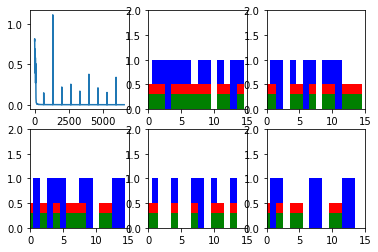

In [69]:
# Running a training session
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []


    for epoch_idx in range(num_epochs):
        x,y = generateData()
        _current_state = np.zeros((batch_size, state_size))
        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()